# Which sentiment is reflected by lyrics of english song during political/economical crisis, in countries where that language is primary ? 

## Packages import

In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Dataset import

In [6]:
USE_COLS = [
    "lyrics",
    "year",
    "language_cld3",
    "language_ft",
    "tag",
    "artist",
    "title",
    "views"
]

chunks = []
CHUNK_SIZE = 50_000  

for chunk in pd.read_csv(
    "song_lyrics_filtered.csv",
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=True,
    engine="python"  
):
    # filtrage immédiat
    chunk = chunk[
        (chunk["language_cld3"] == "en") &
        (chunk["language_ft"] == "en") &
        (chunk["tag"] == "rap")
    ]
    
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

print(df.shape)
df.head()

(964605, 8)


,title,tag,artist,year,views,lyrics,language_cld3,language_ft
0,Killa Cam,rap,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",en,en
1,Can I Live,rap,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...,en,en
3,Down and Out,rap,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...,en,en
4,Fly In,rap,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",en,en


In [7]:
# Suppression des colonnes inutiles
df = df.drop(["language_cld3", "language_ft", "tag"], axis=1)

In [8]:
# Enregistrement du df en parquet
df.to_parquet(
    "data/rap_lyrics.parquet",
    index=False
)

In [2]:
# Chargement du df filtré
df = pd.read_parquet("data/rap_lyrics.parquet")
df.head()

,title,artist,year,views,lyrics
0,Killa Cam,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


## Descriptive statistics

In [ ]:
df.info()
# no missing values 

<class 'pandas.DataFrame'>
RangeIndex: 964605 entries, 0 to 964604
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   title   964538 non-null  str  
 1   artist  964605 non-null  str  
 2   year    964605 non-null  int64
 3   views   964605 non-null  int64
 4   lyrics  964605 non-null  str  
dtypes: int64(2), str(3)
memory usage: 2.1 GB


In [ ]:
df[["year", "views"]].describe()
# Incoherence in values for year and views (min)

,year,views
count,964605.000000,9.646050e+05
mean,2014.790266,5.882038e+03
std,57.264063,8.041827e+04
min,1.000000,0.000000e+00
25%,2015.000000,2.000000e+01
50%,2018.000000,6.900000e+01
75%,2020.000000,5.280000e+02
max,2027.000000,1.757563e+07


In [12]:
songs_per_year = df["year"].value_counts().sort_index()
songs_per_year.head()

year
1    649
2      6
3      3
5      1
6      6
Name: count, dtype: int64

In [ ]:
# Filter to keep only years between 1950 and 2023
df = df[(df["year"] >= 1950) & (df["year"] <= 2023)]
df.shape

(963628, 5)

In [ ]:
df["year"].describe()
# Now, the values make sense

count    963628.000000
mean       2016.463142
std           5.523159
min        1950.000000
25%        2015.000000
50%        2018.000000
75%        2020.000000
max        2023.000000
Name: year, dtype: float64

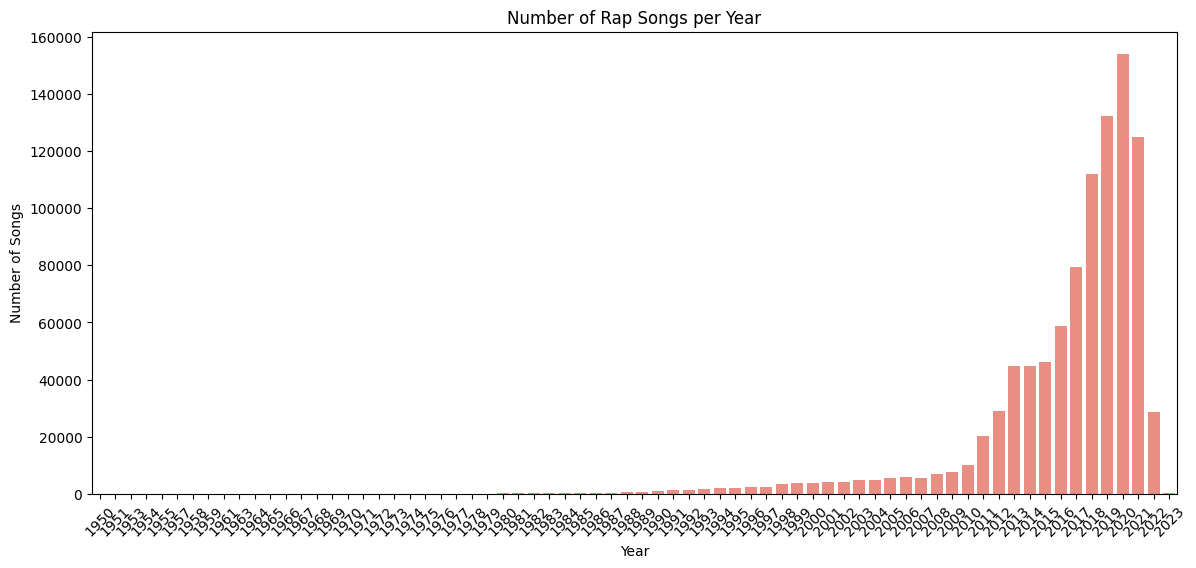

In [20]:
songs_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, color="salmon")
plt.title("Number of Rap Songs per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()

In [3]:
# Keeping only the years 2000s
df = df[(df["year"] >= 2000) & (df["year"] <= 2023)]
df.shape

(938866, 5)

In [22]:
df["artist"].value_counts().head(10)

artist
Genius English Translations    3707
Lil B                          1287
Gucci Mane                     1184
Juice WRLD                     1135
Lil Wayne                      1003
Chief Keef                      919
Muze Sikk                       917
OCTOBERSFULLMOON                886
BONES                           773
Kanye West                      768
Name: count, dtype: int64

## Pre processing

## NLP 

In [4]:
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

def clean_lyrics(text):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()
    tokens = [
        w for w in text.split()
        if w not in STOPWORDS and len(w) > 2
    ]
    return " ".join(tokens)

df["clean_lyrics"] = df["lyrics"].astype(str).apply(clean_lyrics)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isali\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [18]:
df["clean_lyrics"].head()

0    killa cam killa cam cam killa cam killa cam ki...
2    maybe cause eatin bastards fiend grub carry pu...
3    ugh killa baby kanye heron flow huh yeah let s...
4    ask young boy gon second time around gon come ...
5    haha huh homo young mula baby say sweet make w...
Name: clean_lyrics, dtype: str

In [6]:
df.to_parquet(
    "data/rap_lyrics_nlp_clean.parquet",
    index=False
)

In [5]:
analyzer = SentimentIntensityAnalyzer()

def vader_score(text):
    return analyzer.polarity_scores(text)["compound"]

df["sentiment"] = df["clean_lyrics"].apply(vader_score)

KeyboardInterrupt: 

In [19]:
analyzer = SentimentIntensityAnalyzer()

def vader_score(text):
    return analyzer.polarity_scores(text)["compound"]

df_small = df.iloc[:100_000].copy()
df_small["sentiment"] = df_small["clean_lyrics"].apply(vader_score)

In [38]:
import numpy as np

# On fixe le nombre total de chansons à 50 000
total_songs = 50_000
years = df['year'].sort_values().unique()
n_years = len(years)

# Calcul du nombre de chansons par année (environ égal)
songs_per_year = total_songs // n_years

# On crée un nouveau DF avec les chansons les plus vues par année
df_top = (
    df
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(songs_per_year)
)

print(f"Total songs selected: {len(df_top)}")
df_top["year"].value_counts().sort_index()


Total songs selected: 48085


year
2000    2083
2001    2083
2002    2083
2003    2083
2004    2083
2005    2083
2006    2083
2007    2083
2008    2083
2009    2083
2010    2083
2011    2083
2012    2083
2013    2083
2014    2083
2015    2083
2016    2083
2017    2083
2018    2083
2019    2083
2020    2083
2021    2083
2022    2083
2023     176
Name: count, dtype: int64

In [39]:
df_top["rank_within_year"] = df_top.groupby("year")["views"].rank(method="first", ascending=False)
# par contre, on a pas la date des views, donc la chanson a pu être populaire à une autre année

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df_top["sentiment"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_top["sentiment_neg"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_top["sentiment_pos"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_top["sentiment_neu"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [8]:
df_sample = (
    df
    .groupby("year", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 2000), random_state=42))
)

In [15]:
df_sample["sentiment"] = df_sample["clean_lyrics"].apply(
    lambda x: analyzer.polarity_scores(x[:1000])["compound"]
)

KeyboardInterrupt: 

In [16]:
df_sample.index

RangeIndex(start=0, stop=46176, step=1)

In [14]:
df_sample = (
    df
    .groupby("year", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 2000), random_state=42))
    .reset_index(drop=False)
)

In [17]:
df_sample.head()

,index,title,artist,views,lyrics,clean_lyrics
0,7026,Thats Right,Amil,1769,[Intro: Jay-Z (Amil)]\nThis how I creep up on ...,creep ass blaze see beat building creep ass bl...
1,173293,“Happiness” Dead Prez,dead prez,46,"[Verse 1]\nYo, it's a beautiful day, and every...",beautiful day everybody feelin wonderful ladie...
2,22124,Sacrifice,Jedi Mind Tricks,16166,[Intro]\nYou've watched so many people die now...,watched many people die sacrifice word others ...
3,44095,Trecherous,Young Bleed,141,"[Intro]\nIt's goin' down\nYo, yo, yo, yo, yo, ...",goin check though nothin shit treacherous mode...
4,39483,Dope House Intro,South Park Mexican,907,"Dope House Records....\nDope sells itself, BIA...",dope house records dope sells biatch real alwa...


In [10]:
sentiment_year = (
    df_sample
    .groupby("year")["sentiment"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=sentiment_year,
    x="year",
    y="sentiment",
    marker="o"
)

plt.axhline(0, color="black", linestyle="--", alpha=0.6)
plt.title("Average Sentiment of Rap Lyrics per Year (VADER)")
plt.xlabel("Year")
plt.ylabel("Mean Sentiment (compound)")
plt.grid(alpha=0.3)
plt.show()


KeyError: 'year'

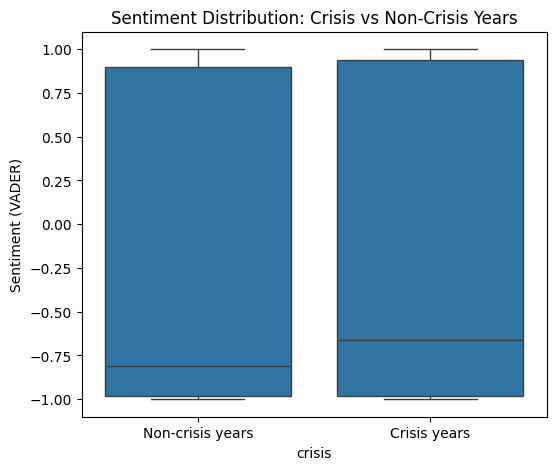

In [41]:
crisis_years = [
    1991,  # Gulf War
    2001,  # 9/11
    2008, 2009,  # Financial crisis
    2020, 2021  # COVID
]

df_top["crisis"] = df_top["year"].isin(crisis_years)

plt.figure(figsize=(6,5))
sns.boxplot(
    data=df_top,
    x="crisis",
    y="sentiment"
)

plt.xticks([0,1], ["Non-crisis years", "Crisis years"])
plt.title("Sentiment Distribution: Crisis vs Non-Crisis Years")
plt.ylabel("Sentiment (VADER)")
plt.show()


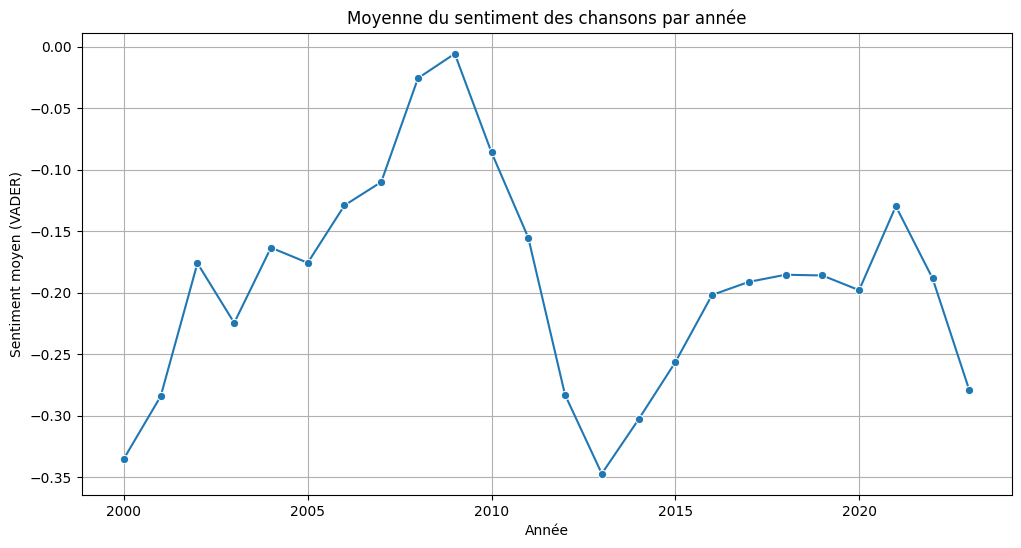

In [42]:
sentiment_year = df_top.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o")
plt.title("Moyenne du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.grid(True)
plt.show()

In [31]:
us_event_years = {
    2001: "Attentats du 11 septembre",
    2003: "Guerre en Irak commence",
    2005: "Ouragan Katrina",
    2008: "Crise financière mondiale / élection Obama",
    2010: "Deepwater Horizon (marée noire)",
    2012: "Réélection Obama, hausse des tensions sociales",
    2014: "Mouvement Black Lives Matter prend de l'ampleur après Ferguson",
    2016: "Élection Trump",
    2020: "Pandémie COVID-19 / manifestations BLM après la mort de George Floyd",
    2021: "Assaut du Capitole",
}

# Pour visualiser ou filtrer facilement
us_crisis_years = list(us_event_years.keys())

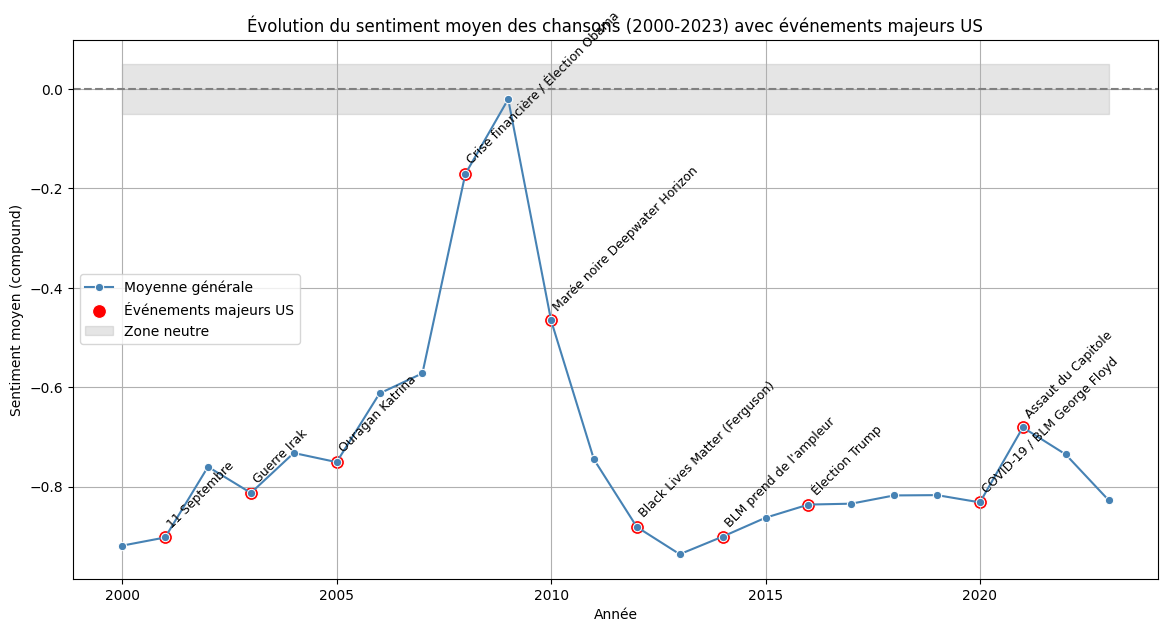

In [45]:
# 1️⃣ Calcul du sentiment moyen par année pour tout le df_top
sentiment_year = df_top.groupby("year")["sentiment"].median()

# 2️⃣ Filtrer le df pour les années des événements US
us_event_years = {
    2001: "11 Septembre",
    2003: "Guerre Irak",
    2005: "Ouragan Katrina",
    2008: "Crise financière / Élection Obama",
    2010: "Marée noire Deepwater Horizon",
    2012: "Black Lives Matter (Ferguson)",
    2014: "BLM prend de l'ampleur",
    2016: "Élection Trump",
    2020: "COVID-19 / BLM George Floyd",
    2021: "Assaut du Capitole"
}
df_us_events = df_top[df_top["year"].isin(us_event_years.keys())]
sentiment_us_events = df_us_events.groupby("year")["sentiment"].median()

# 3️⃣ Graphique
plt.figure(figsize=(14,7))

# Ligne sentiment moyen général
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o", color="steelblue", label="Moyenne générale")

# Points pour années clés US
sns.scatterplot(x=sentiment_us_events.index, y=sentiment_us_events.values, color="red", s=100, label="Événements majeurs US")

# Ajouter les annotations pour chaque événement
for year, event in us_event_years.items():
    if year in sentiment_us_events.index:
        plt.text(year, sentiment_us_events.loc[year] + 0.02, event, rotation=45, fontsize=9, ha='left')

# Ligne neutre
plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre")

# Labels et titre
plt.title("Évolution du sentiment moyen des chansons (2000-2023) avec événements majeurs US")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (compound)")
plt.legend()
plt.grid(True)
plt.show()

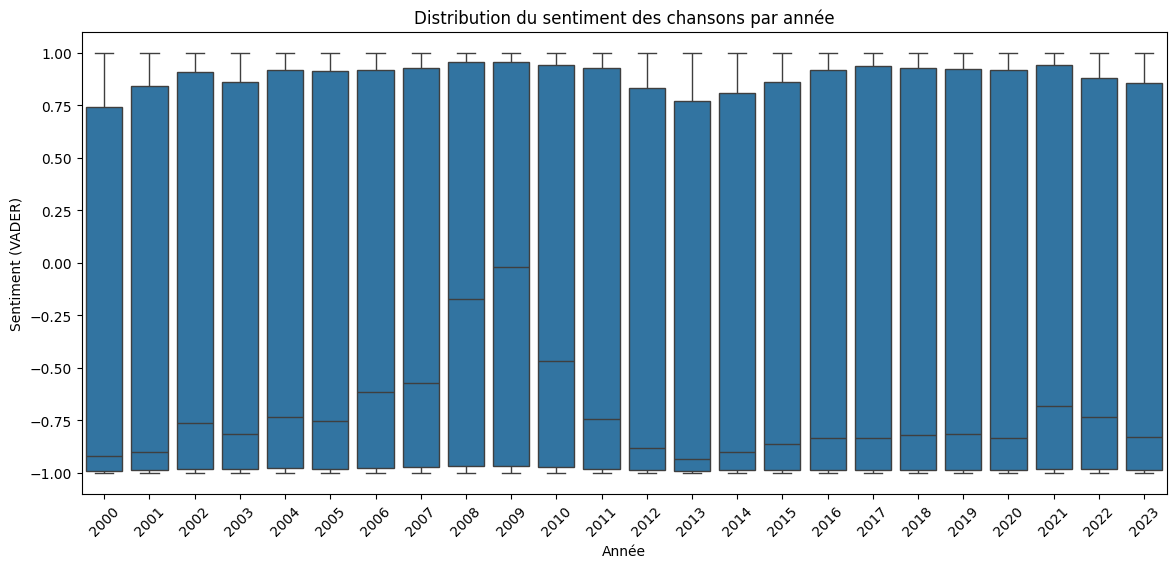

In [46]:
plt.figure(figsize=(14,6))
sns.boxplot(x="year", y="sentiment", data=df_top)
plt.title("Distribution du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment (VADER)")
plt.xticks(rotation=45)
plt.show()

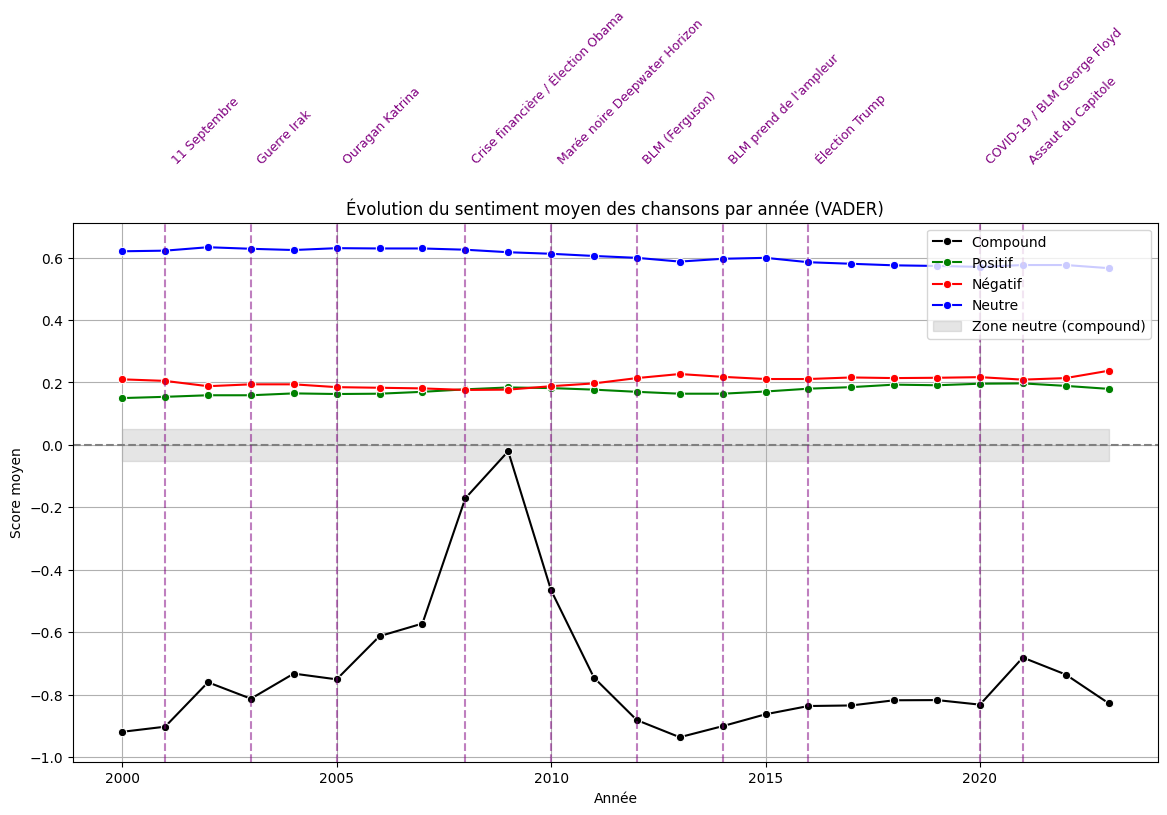

In [47]:
# Moyenne des scores par année
sentiment_by_year = df_top.groupby("year")[
    ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]
].median()

plt.figure(figsize=(14,7))

# Tracer toutes les lignes
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment"], 
             marker="o", color="black", label="Compound")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_pos"], 
             marker="o", color="green", label="Positif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neg"], 
             marker="o", color="red", label="Négatif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neu"], 
             marker="o", color="blue", label="Neutre")

# Ligne neutre pour compound
plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_by_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre (compound)")

# Ajouter les événements majeurs US si tu veux
us_event_years = {
    2001: "11 Septembre",
    2003: "Guerre Irak",
    2005: "Ouragan Katrina",
    2008: "Crise financière / Élection Obama",
    2010: "Marée noire Deepwater Horizon",
    2012: "BLM (Ferguson)",
    2014: "BLM prend de l'ampleur",
    2016: "Élection Trump",
    2020: "COVID-19 / BLM George Floyd",
    2021: "Assaut du Capitole"
}
for year, event in us_event_years.items():
    if year in sentiment_by_year.index:
        plt.axvline(year, color="purple", linestyle="--", alpha=0.5)
        plt.text(year+0.1, 0.9, event, rotation=45, fontsize=9, color="purple")

# Labels et titre
plt.title("Évolution du sentiment moyen des chansons par année (VADER)")
plt.xlabel("Année")
plt.ylabel("Score moyen")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Moyenne et médiane des scores VADER par année
sentiment_stats = df_top.groupby("year")[["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]].agg(
    ["mean", "median"]
)

# Affichage
print(sentiment_stats)


     sentiment          sentiment_pos         sentiment_neg          \
          mean   median          mean  median          mean  median   
year                                                                  
2000 -0.382867 -0.92145      0.161279  0.1495      0.222041  0.2145   
2001 -0.283030 -0.90620      0.162769  0.1535      0.215889  0.2045   
2002 -0.146547 -0.68080      0.176817  0.1630      0.198195  0.1885   
2003 -0.123873 -0.63305      0.189087  0.1685      0.194889  0.1865   
2004 -0.159701 -0.74300      0.176493  0.1650      0.193930  0.1870   
2005 -0.094373 -0.56160      0.185918  0.1730      0.190788  0.1820   
2006 -0.156108 -0.67050      0.176974  0.1665      0.192647  0.1875   
2007  0.015869  0.14030      0.193983  0.1845      0.181091  0.1690   
2008  0.023268  0.11915      0.199192  0.1875      0.181654  0.1720   
2009 -0.062020 -0.39580      0.197517  0.1895      0.198060  0.1875   
2010 -0.098984 -0.52580      0.195856  0.1880      0.204351  0.2005   
2011 -

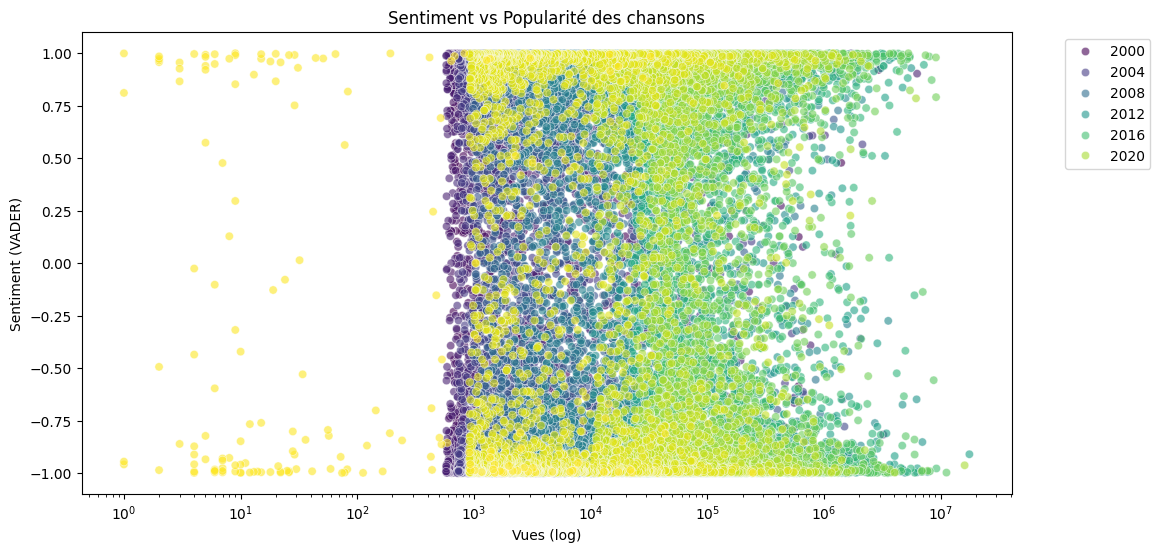

In [48]:
plt.figure(figsize=(12,6))
sns.scatterplot(x="views", y="sentiment", hue="year", data=df_top, palette="viridis", alpha=0.6)
plt.xscale("log")  # Comme les vues varient énormément
plt.title("Sentiment vs Popularité des chansons")
plt.xlabel("Vues (log)")
plt.ylabel("Sentiment (VADER)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


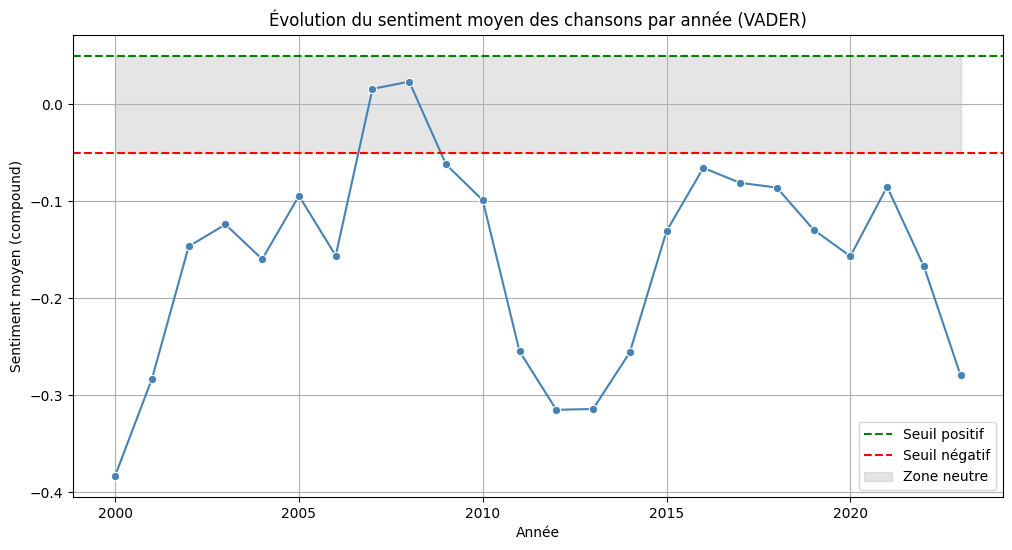

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul du sentiment moyen par année
sentiment_year = df_top.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o", color="steelblue")

# Zones d'interprétation
plt.axhline(0.05, color="green", linestyle="--", label="Seuil positif")
plt.axhline(-0.05, color="red", linestyle="--", label="Seuil négatif")
plt.fill_between(sentiment_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre")

# Labels et titre
plt.title("Évolution du sentiment moyen des chansons par année (VADER)")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (compound)")
plt.legend()
plt.grid(True)
plt.show()


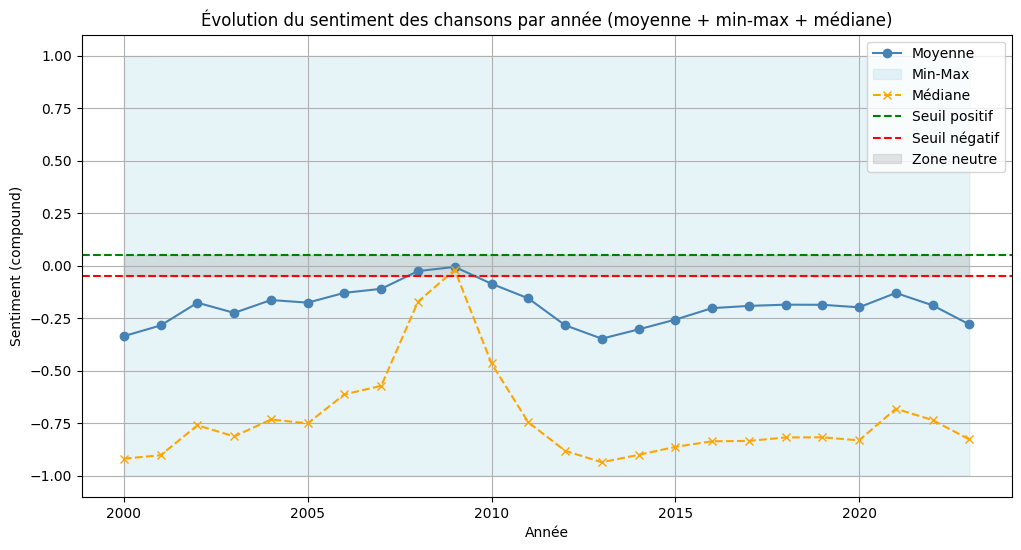

In [49]:
sentiment_stats = df_top.groupby("year")["sentiment"].agg(["mean", "min", "max", "median"])

plt.figure(figsize=(12,6))
plt.plot(sentiment_stats.index, sentiment_stats["mean"], marker="o", label="Moyenne", color="steelblue")
plt.fill_between(sentiment_stats.index, sentiment_stats["min"], sentiment_stats["max"], color="lightblue", alpha=0.3, label="Min-Max")
plt.plot(sentiment_stats.index, sentiment_stats["median"], marker="x", linestyle="--", label="Médiane", color="orange")

plt.axhline(0.05, color="green", linestyle="--", label="Seuil positif")
plt.axhline(-0.05, color="red", linestyle="--", label="Seuil négatif")
plt.fill_between(sentiment_stats.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre")

plt.title("Évolution du sentiment des chansons par année (moyenne + min-max + médiane)")
plt.xlabel("Année")
plt.ylabel("Sentiment (compound)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
nrc = pd.read_csv(
    "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep="\t",
    names=["word", "emotion", "association"]
)

nrc = nrc[nrc["association"] == 1]

emotion_map = (
    nrc.groupby("word")["emotion"]
    .apply(list)
    .to_dict()
)

def emotional_power(text):
    emotions = []
    for w in text.split():
        emotions.extend(emotion_map.get(w, []))
    return len(emotions)

df["emotional_power"] = df["clean_lyrics"].apply(emotional_power)


In [ ]:
yearly_stats = (
    df.groupby("year")
      .agg(
          mean_sentiment=("sentiment", "mean"),
          mean_emotion=("emotional_power", "mean"),
          song_count=("lyrics", "count")
      )
      .reset_index()
)

yearly_stats.head()


## Visualisation of the results

In [ ]:
CRISIS_YEARS = {
    "dotcom": list(range(2000, 2003)),
    "financial_crisis": list(range(2008, 2010)),
    "covid": list(range(2020, 2022))
}

crisis_years = sum(CRISIS_YEARS.values(), [])

yearly_stats["crisis"] = yearly_stats["year"].isin(crisis_years)